In [1]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

# Cell 1: Imports and setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
from scripts.MNIST.MNISTmodel import MILModel

# Reproducibilidad
torch.manual_seed(42)

# Hyperparámetros
target_digit = 3       # Dígito objetivo para las bolsas
bag_size = 10          # Número de instancias por bolsa
num_epochs = 10        # Número de épocas
a_learning_rate = 1e-3  # Tasa de aprendizaje
batch_size = 1         # Tamaño de lote
pooling_type = 'mean'  # 'attention', 'mean' o 'max'

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Cell 2: Dataset y DataLoaders
full_train_dataset = MNISTMILDataset(subset='train', bag_size=bag_size, obj_label=target_digit)
test_dataset = MNISTMILDataset(subset='test', bag_size=bag_size, obj_label=target_digit)

# División train/validation
total_train = len(full_train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

# Cell 3: Modelo, criterio y optimizador
model = MILModel(pooling_type=pooling_type).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=a_learning_rate)

# Cell 4: Loop de entrenamiento
def train():
    model.train()
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        for bag, bag_label, inst_labels, lap in dataloader_train:
            bag = bag.to(device)
            bag_label = bag_label.to(device)

            optimizer.zero_grad()
            output, attn = model(bag)
            loss = criterion(output.squeeze(-1), bag_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader_train)
        print(f"Época {epoch}/{num_epochs} - Loss: {avg_loss:.4f}")

train()

# Cell 5: Evaluación en test set
model.eval()
all_outputs, all_labels = [], []
with torch.no_grad():
    for bag, bag_label, inst_labels, lap in dataloader_test:
        bag = bag.to(device)
        bag_label = bag_label.to(device)
        output, attn = model(bag)
        all_outputs.append(output.cpu())
        all_labels.append(bag_label.cpu())

# Métricas
torch_outputs = torch.cat(all_outputs).squeeze()
torch_labels = torch.cat(all_labels)
accuracy = ((torch_outputs > 0.5).float() == torch_labels).float().mean()
print(f"Accuracy en test: {accuracy:.4f}")

# Visualización de pesos de atención (si aplica)
if pooling_type == 'attention':
    import matplotlib.pyplot as plt
    bag, _, _, _ = next(iter(dataloader_test))
    _, attn_weights = model(bag.to(device))
    attn_weights = attn_weights.cpu().numpy()[0]
    plt.bar(range(len(attn_weights)), attn_weights)
    plt.title('Pesos de atención para una bolsa de prueba')
    plt.show()


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Usando dispositivo: cuda
Época 1/10 - Loss: 0.4377
Época 2/10 - Loss: 0.1568
Época 3/10 - Loss: 0.0872
Época 4/10 - Loss: 0.0645
Época 5/10 - Loss: 0.0518
Época 6/10 - Loss: 0.0396
Época 7/10 - Loss: 0.0284
Época 8/10 - Loss: 0.0247
Época 9/10 - Loss: 0.0177
Época 10/10 - Loss: 0.0158
Accuracy en test: 0.9800


Usando dispositivo: cuda


Época 1/10 - Loss: 0.4348
Época 2/10 - Loss: 0.1603
Época 3/10 - Loss: 0.0974
Época 4/10 - Loss: 0.0670
Época 5/10 - Loss: 0.0483
Época 6/10 - Loss: 0.0345
Época 7/10 - Loss: 0.0279
Época 8/10 - Loss: 0.0229
Época 9/10 - Loss: 0.0195
Época 10/10 - Loss: 0.0112
Accuracy en test: 0.9880


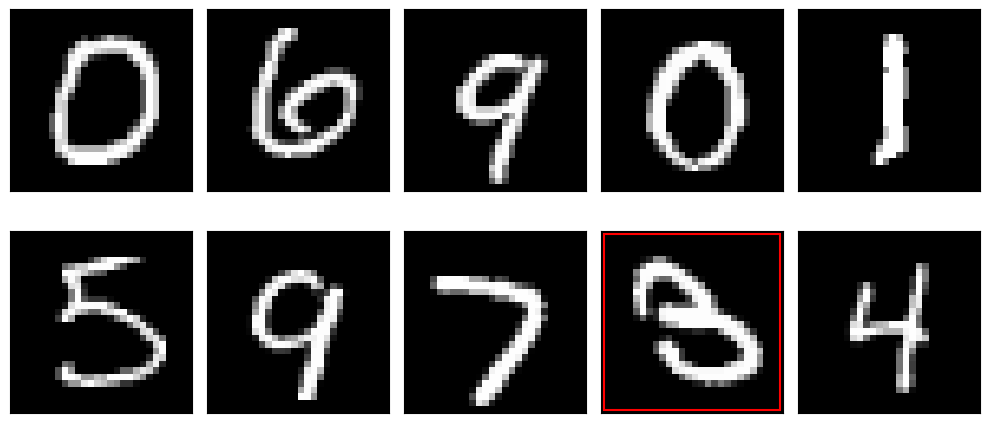

In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
from scripts.MNIST.MNISTmodel import MILModel

# Reproducibilidad
torch.manual_seed(42)

# Hyperparámetros
target_digit = 3       # Dígito objetivo para las bolsas
bag_size = 10          # Número de instancias por bolsa
num_epochs = 10        # Número de épocas
a_learning_rate = 1e-3  # Tasa de aprendizaje
batch_size = 1         # Tamaño de lote
pooling_type = 'mean'  # 'attention', 'mean' o 'max'

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Dataset y DataLoaders
full_train_dataset = MNISTMILDataset(subset='train', bag_size=bag_size, obj_label=target_digit)
test_dataset = MNISTMILDataset(subset='test', bag_size=bag_size, obj_label=target_digit)

# División train/validation
total_train = len(full_train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

# Modelo, criterio y optimizador
model = MILModel(pooling_type=pooling_type).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=a_learning_rate)

# Loop de entrenamiento
def train():
    model.train()
    for epoch in range(1, num_epochs+1):
        total_loss = 0.0
        for bag, bag_label, inst_labels, lap in dataloader_train:
            bag = bag.to(device)
            bag_label = bag_label.to(device)

            optimizer.zero_grad()
            output, attn = model(bag)
            loss = criterion(output.squeeze(-1), bag_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader_train)
        print(f"Época {epoch}/{num_epochs} - Loss: {avg_loss:.4f}")

train()

# Evaluación en test set
model.eval()
all_outputs, all_labels = [], []
with torch.no_grad():
    for bag, bag_label, inst_labels, lap in dataloader_test:
        bag = bag.to(device)
        bag_label = bag_label.to(device)
        output, attn = model(bag)
        all_outputs.append(output.cpu())
        all_labels.append(bag_label.cpu())

# Métricas
torch_outputs = torch.cat(all_outputs).squeeze()
torch_labels = torch.cat(all_labels)
accuracy = ((torch_outputs > 0.5).float() == torch_labels).float().mean()
print(f"Accuracy en test: {accuracy:.4f}")

# Visualización de la PRIMERA bolsa de prueba que contenga una instancia positiva
model.eval()
with torch.no_grad():
    found_positive_bag = False
    for bag, bag_label, inst_labels, _ in dataloader_test:
        # Check if this bag is positive (contains at least one target digit)
        if bag_label.item() == 1:
            found_positive_bag = True
            bag = bag.cpu().squeeze(0)  # Remove batch dimension
            inst_labels = inst_labels.cpu().squeeze(0) # Remove batch dimension
            
            fig, axes = plt.subplots(2, 5, figsize=(10, 5)) # Assuming bag_size = 10 (2 rows, 5 columns)
            axes = axes.flatten()

            for i in range(bag.shape[0]):
                ax = axes[i]
                ax.imshow(bag[i].squeeze().numpy(), cmap='gray')
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_aspect('equal') # Ensure images are square

                # Draw a red rectangle if it's a positive instance
                if inst_labels[i] == 1:
                    # Coordinates for rectangle (x, y), width, height. Image size is 28x28.
                    rect = patches.Rectangle((0, 0), 27, 27, linewidth=1.5, edgecolor='r', facecolor='none') 
                    ax.add_patch(rect)
            
            plt.tight_layout()
            plt.show()
            break # Exit the loop after finding and displaying the first positive bag

    if not found_positive_bag:
        print("No positive bag found in the test dataset to display.")

Usando dispositivo: cuda


/tmp/ipykernel_838434/2892206647.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


Modelo cargado exitosamente desde: /home/javitrucas/TFG/notebooks/models/attention/model.pth

Generando visualización de atención para 5 bolsas de MNIST (2x5 horizontal, separadas y con alpha normalizado)...


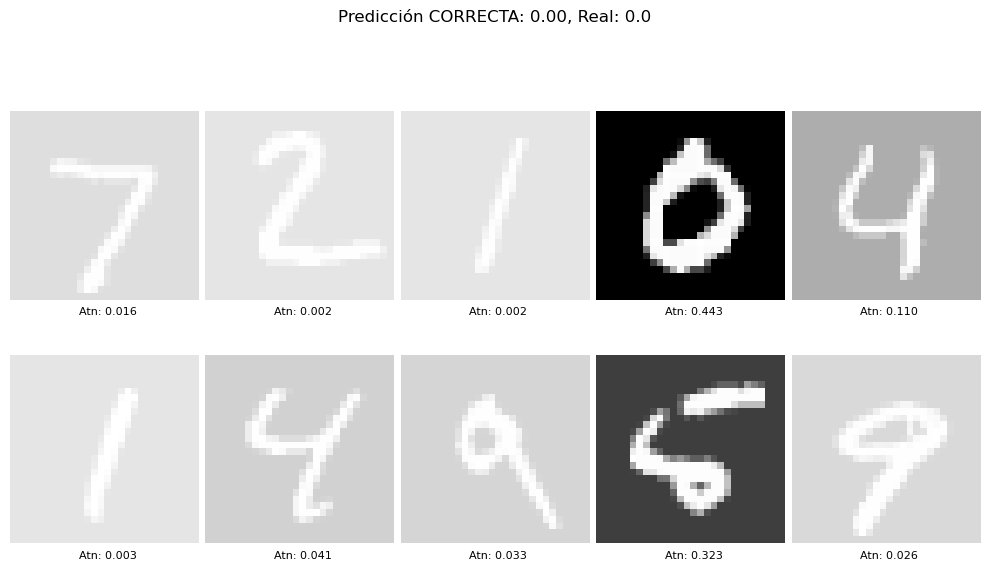

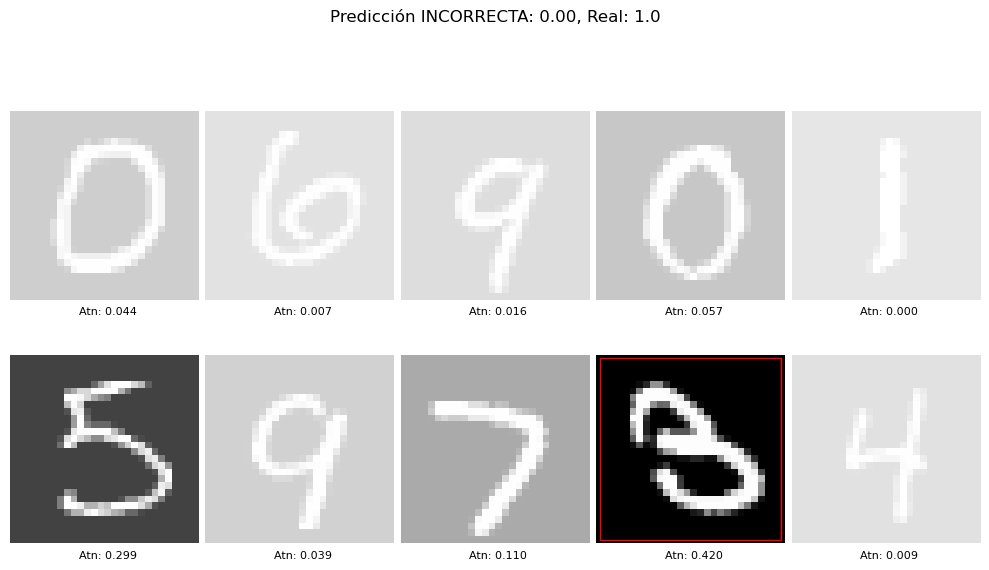

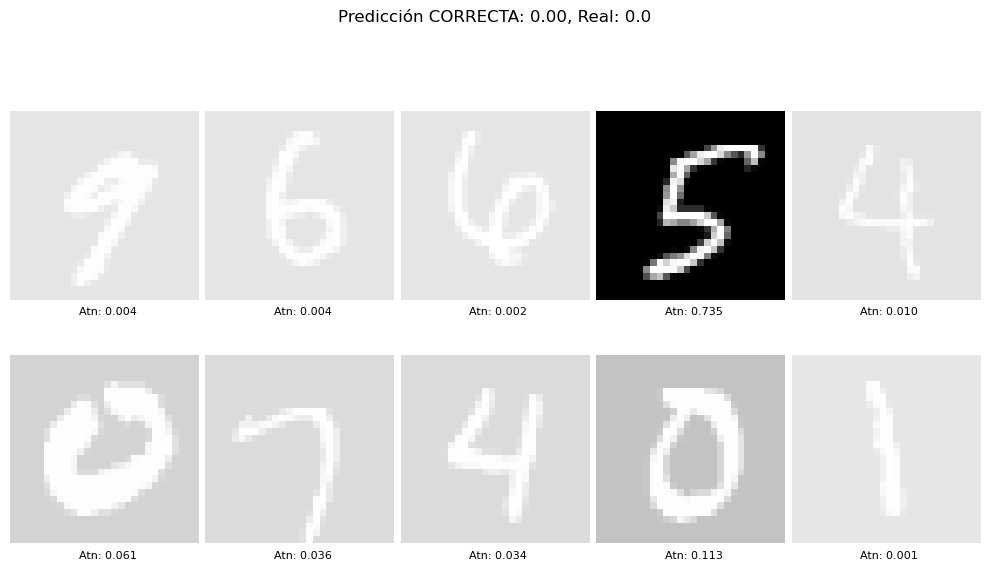

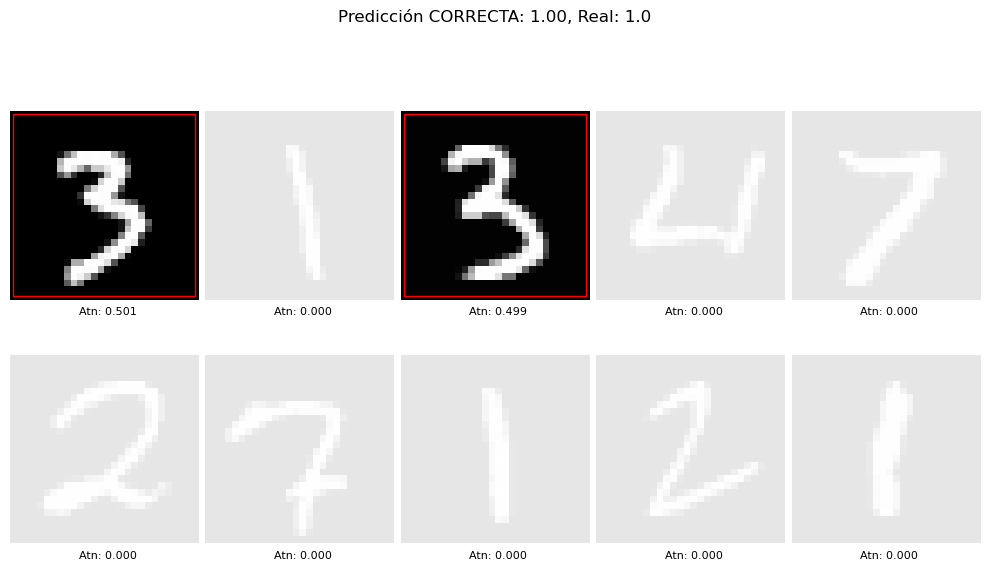

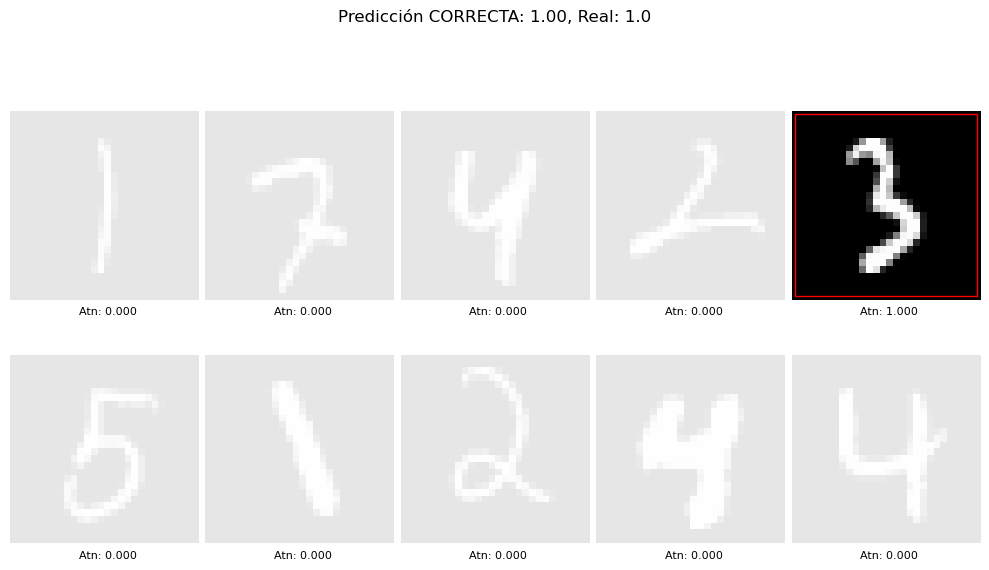


Proceso de visualización completado.


In [5]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# --- CONFIGURACIÓN DE RUTAS E IMPORTACIONES ---
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

# Importar las clases necesarias
try:
    from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
    from scripts.MNIST.MNISTmodel import MILModel
except ImportError as e:
    print(f"Error al importar módulos del proyecto: {e}")
    print("Asegúrate de que la ruta del proyecto y los archivos 'MNISTMILDataset.py' y 'MNISTmodel.py' son correctos.")
    sys.exit(1)

# Ruta al modelo pre-entrenado
MODEL_PATH = "/home/javitrucas/TFG/notebooks/models/attention/model.pth"

# Reproducibilidad
torch.manual_seed(42)

# Hyperparámetros
target_digit = 3
bag_size = 10
batch_size = 1
pooling_type = 'attention'

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Dataset y DataLoaders
full_train_dataset = MNISTMILDataset(subset='train', bag_size=bag_size, obj_label=target_digit)
test_dataset = MNISTMILDataset(subset='test', bag_size=bag_size, obj_label=target_digit)

total_train = len(full_train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

# Modelo
model = MILModel(pooling_type=pooling_type).to(device)

# --- Cargar el modelo pre-entrenado ---
if os.path.exists(MODEL_PATH):
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        print(f"Modelo cargado exitosamente desde: {MODEL_PATH}")
    except Exception as e:
        print(f"Error al cargar el modelo: {e}")
        print("Asegúrate de que la arquitectura del modelo coincide con el archivo .pth")
        sys.exit(1)
else:
    print(f"Advertencia: El archivo del modelo no se encontró en {MODEL_PATH}.")
    print("Por favor, asegúrate de que el modelo esté entrenado y guardado en esa ruta.")
    sys.exit(1)

model.eval()

# --- Función de Visualización Final ---
def visualize_attention_bags_separated(model, dataloader, num_bags_to_display=5):
    """
    Visualiza 5 bolsas separadas, cada una con un formato de 2x5 instancias (horizontal),
    normalizando la opacidad por los pesos de atención, y con texto de atención limpio.
    """
    displayed_bags = 0
    bag_iter = iter(dataloader)

    min_alpha_val = 0.1
    max_alpha_val = 1.0

    with torch.no_grad():
        while displayed_bags < num_bags_to_display:
            try:
                bag, bag_label, inst_labels, _ = next(bag_iter)
            except StopIteration:
                print(f"Se agotaron las bolsas en el dataloader después de {displayed_bags} visualizadas.")
                break

            bag = bag.to(device)
            bag_label = bag_label.to(device)
            inst_labels = inst_labels.to(device)

            current_bag_images = bag.squeeze(0).cpu().numpy()
            current_bag_label = bag_label.item()
            current_inst_labels = inst_labels.squeeze(0).cpu().numpy()

            output, attn_weights = model(bag)

            prediction = (output.item() > 0.5)
            prediction_text = "CORRECTA" if prediction == current_bag_label else "INCORRECTA"
            
            attn_weights = attn_weights.squeeze(0).cpu().numpy()

            # --- Normalización de pesos de atención para el alpha ---
            max_attn_in_bag = np.max(attn_weights)
            
            scaled_alphas = np.zeros_like(attn_weights)
            if max_attn_in_bag > 0:
                for i, attn_w in enumerate(attn_weights):
                    scaled_alphas[i] = min_alpha_val + (attn_w / max_attn_in_bag) * (max_alpha_val - min_alpha_val)
            else:
                scaled_alphas.fill(min_alpha_val)
            scaled_alphas = np.clip(scaled_alphas, min_alpha_val, max_alpha_val)

            # --- Creación de la figura separada para cada bolsa (2x5 grid) ---
            # Aumentar figsize para dar más espacio vertical para el texto
            fig, axes = plt.subplots(2, 5, figsize=(10, 6)) # Aumentado ligeramente el alto de la figura
            axes = axes.flatten() 

            for i in range(bag_size):
                ax_inst = axes[i]
                
                img = current_bag_images[i].squeeze()
                alpha_val = scaled_alphas[i]

                ax_inst.imshow(img, cmap='gray', alpha=alpha_val)
                ax_inst.axis('off')

                # Dibujar cuadro rojo si es una instancia positiva
                if current_inst_labels[i] == 1:
                    rect = patches.Rectangle((0, 0), img.shape[1]-1, img.shape[0]-1, 
                                             linewidth=1, edgecolor='r', facecolor='none')
                    ax_inst.add_patch(rect)
                
                # --- CAMBIO CLAVE AQUÍ: Posición del texto de atención ---
                # Ajustamos la coordenada Y para que esté justo debajo de la imagen
                # Usamos una posición relativa a la altura de la imagen
                # y va='top' para que el tope del texto se alinee con esa posición.
                ax_inst.text(img.shape[1]/2, img.shape[0] + 2, # Posición en píxeles: 2 píxeles debajo de la imagen
                             f"Atn: {attn_weights[i]:.3f}", 
                             color='black', ha='center', va='bottom', fontsize=8, # va='bottom' para que el texto crezca hacia abajo
                             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

            # Título principal de la bolsa en la figura
            bag_title = f"Predicción {prediction_text}: {output.item():.2f}, Real: {current_bag_label}"
            fig.suptitle(bag_title, fontsize=12, y=0.98) 

            # --- CAMBIO CLAVE AQUÍ: Aumentar el espaciado vertical entre filas ---
            # h_pad para más espacio vertical entre los subplots, en unidades de fuente.
            # w_pad para espacio horizontal.
            plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=3.0, w_pad=0.5) # Aumentado h_pad significativamente
            plt.show()

            displayed_bags += 1

# --- Ejecutar la visualización ---
print("\nGenerando visualización de atención para 5 bolsas de MNIST (2x5 horizontal, separadas y con alpha normalizado)...")
visualize_attention_bags_separated(model, dataloader_test, num_bags_to_display=5)

print("\nProceso de visualización completado.")

Usando dispositivo: cuda


Época 1/10 - Train Loss: 0.2386, Val Loss: 0.1109, Val Acc: 0.9683
Época 2/10 - Train Loss: 0.0893, Val Loss: 0.0807, Val Acc: 0.9725


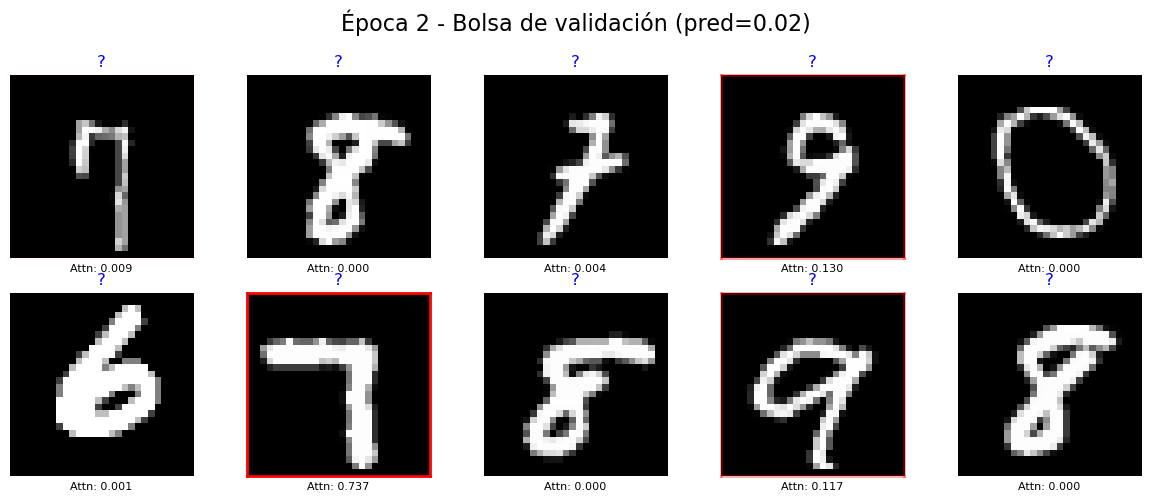

Época 3/10 - Train Loss: 0.0547, Val Loss: 0.0650, Val Acc: 0.9850
Época 4/10 - Train Loss: 0.0417, Val Loss: 0.0461, Val Acc: 0.9842


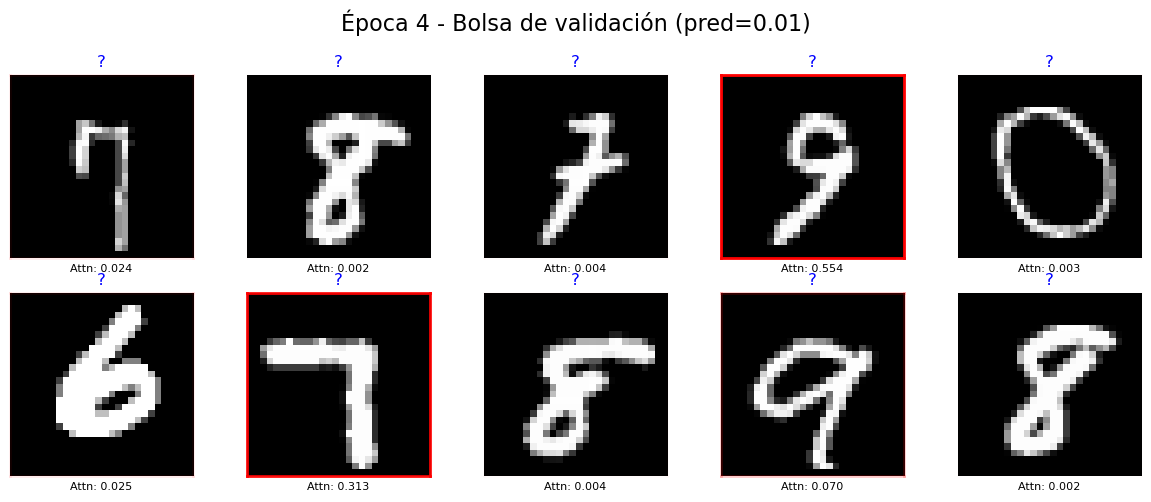

Época 5/10 - Train Loss: 0.0315, Val Loss: 0.0554, Val Acc: 0.9850
Época 6/10 - Train Loss: 0.0298, Val Loss: 0.0848, Val Acc: 0.9742


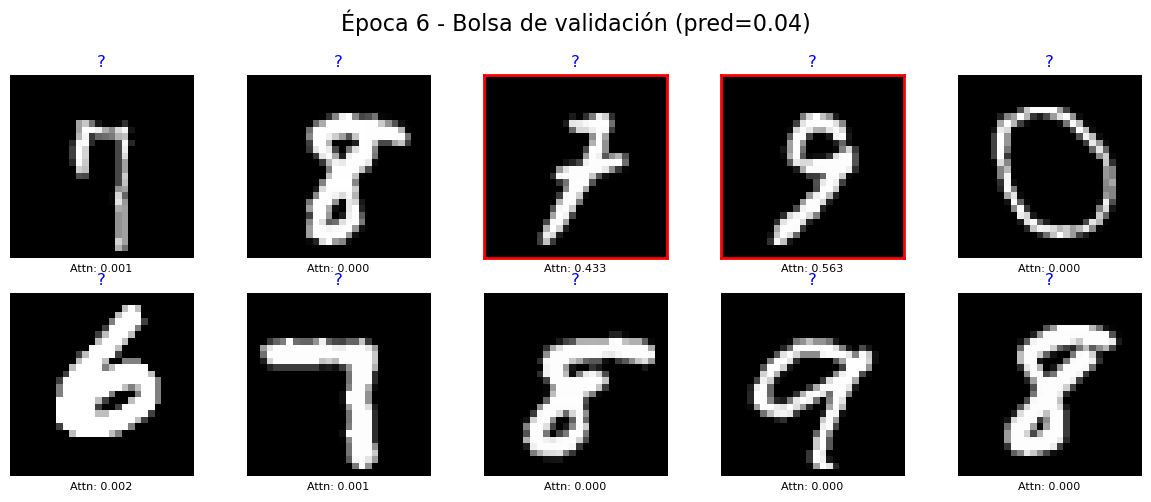

Época 7/10 - Train Loss: 0.0203, Val Loss: 0.0671, Val Acc: 0.9800
Época 8/10 - Train Loss: 0.0163, Val Loss: 0.1039, Val Acc: 0.9817


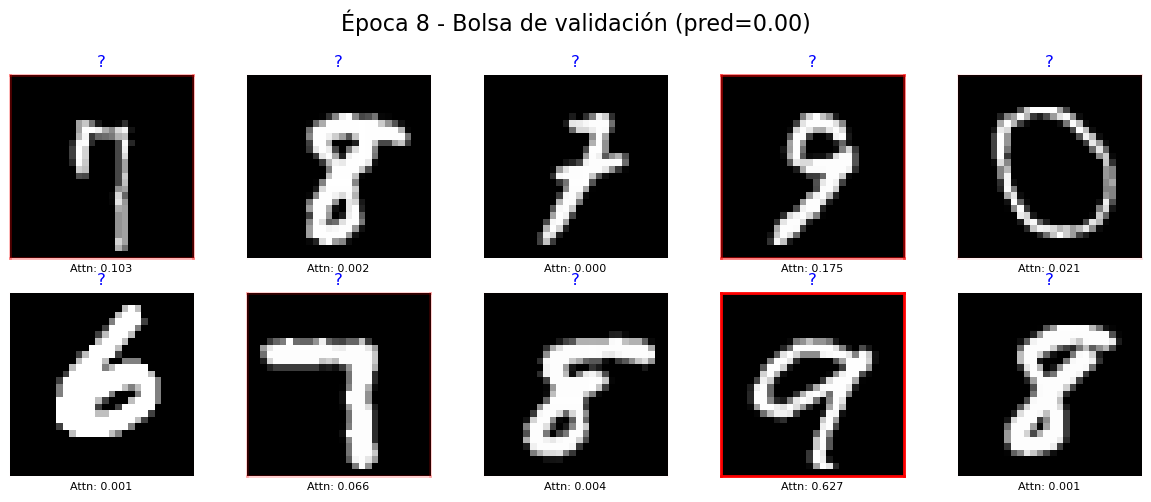

Época 9/10 - Train Loss: 0.0155, Val Loss: 0.0603, Val Acc: 0.9850
Época 10/10 - Train Loss: 0.0128, Val Loss: 0.1085, Val Acc: 0.9833


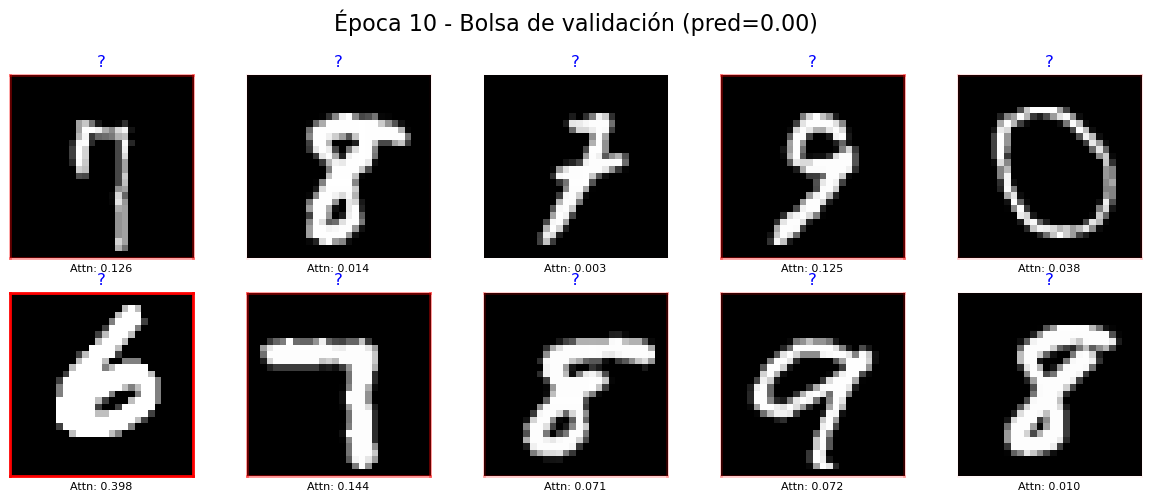

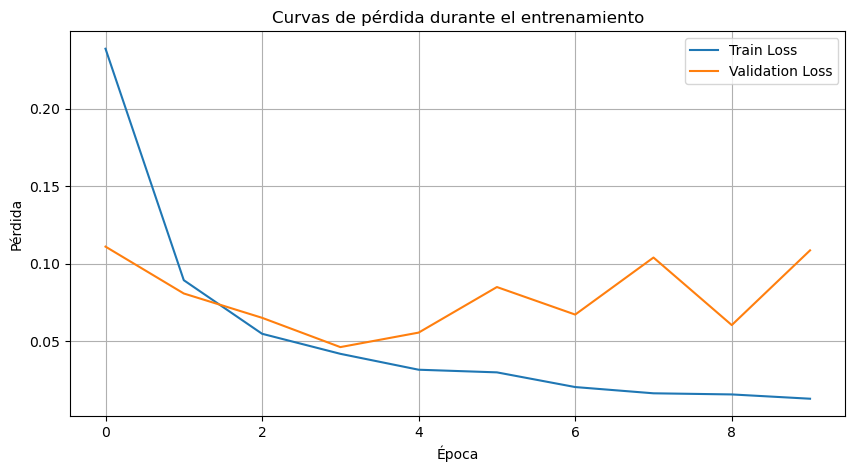

Accuracy en test: 0.9890


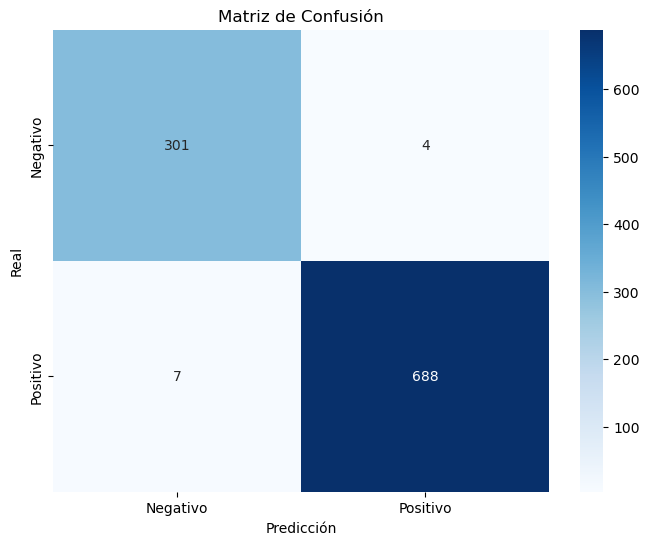

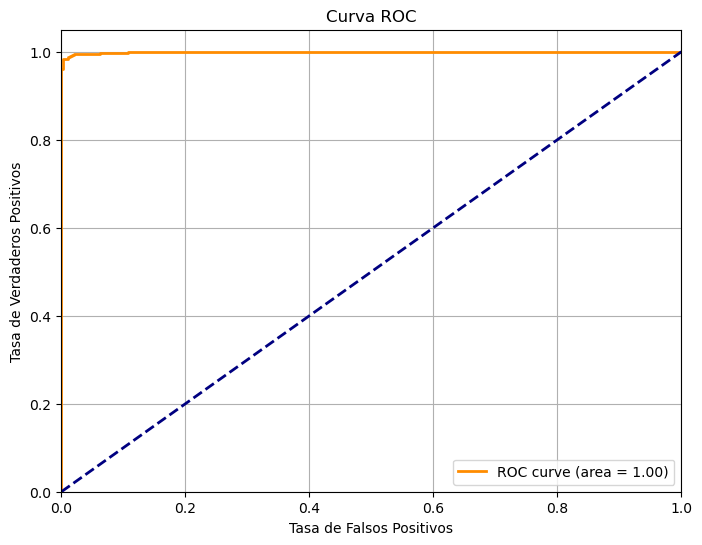

Predicciones correctas: 989
Predicciones incorrectas: 11


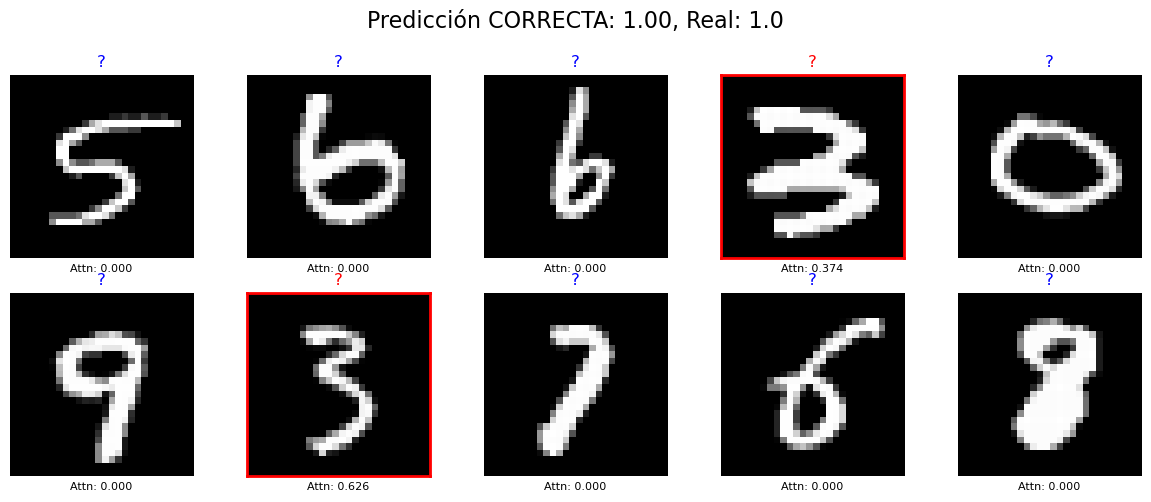

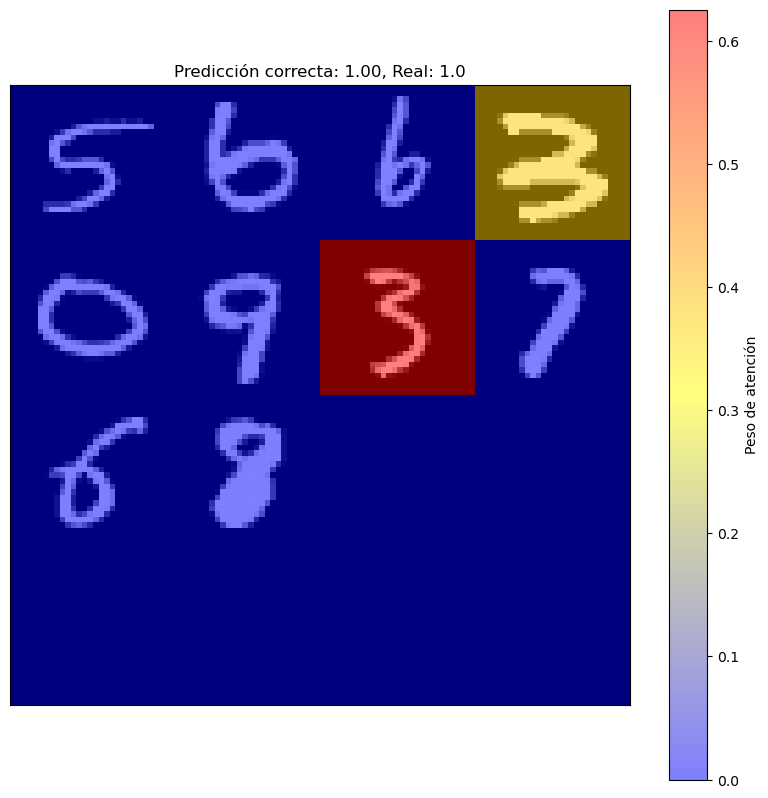

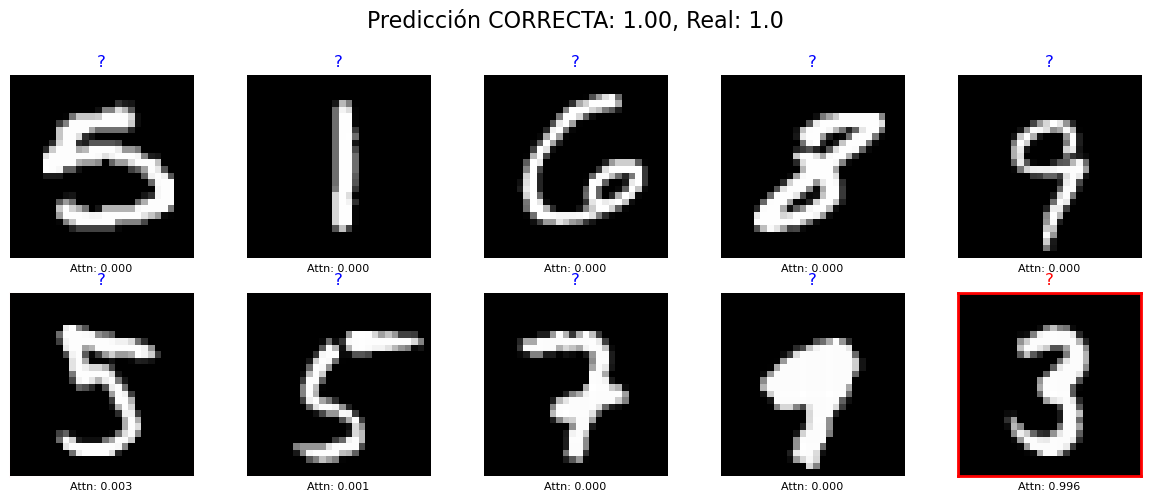

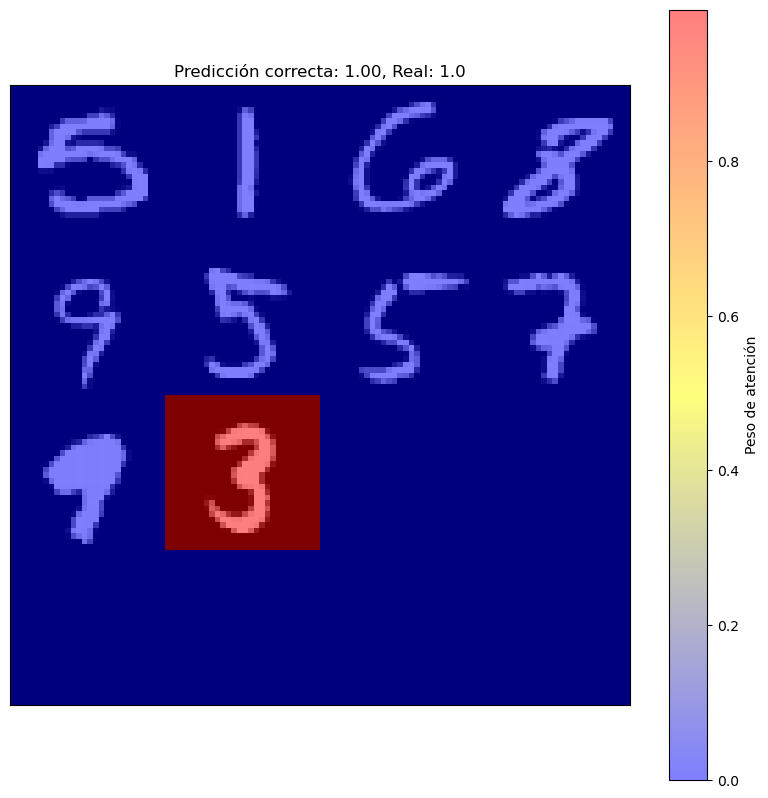

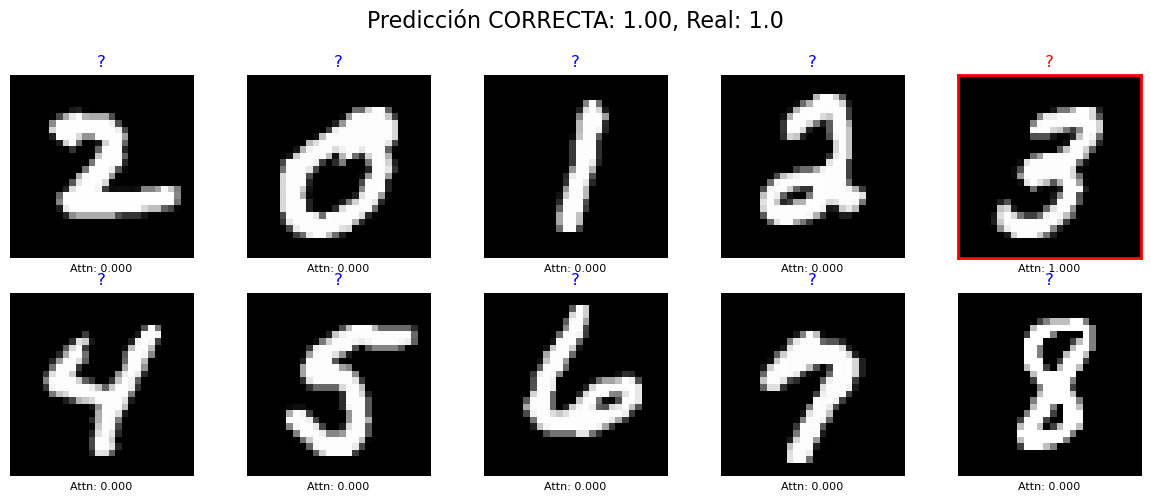

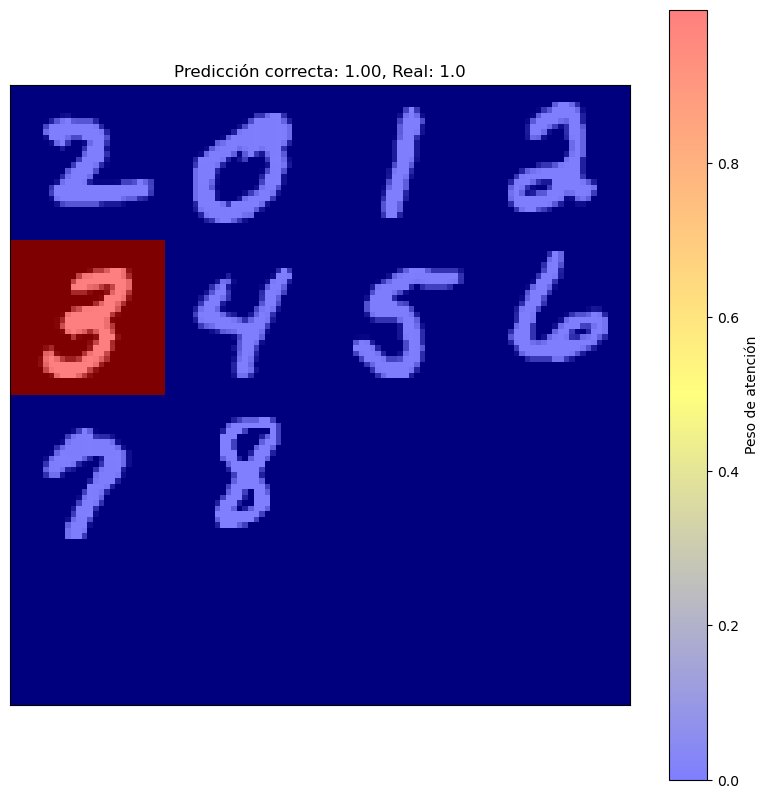

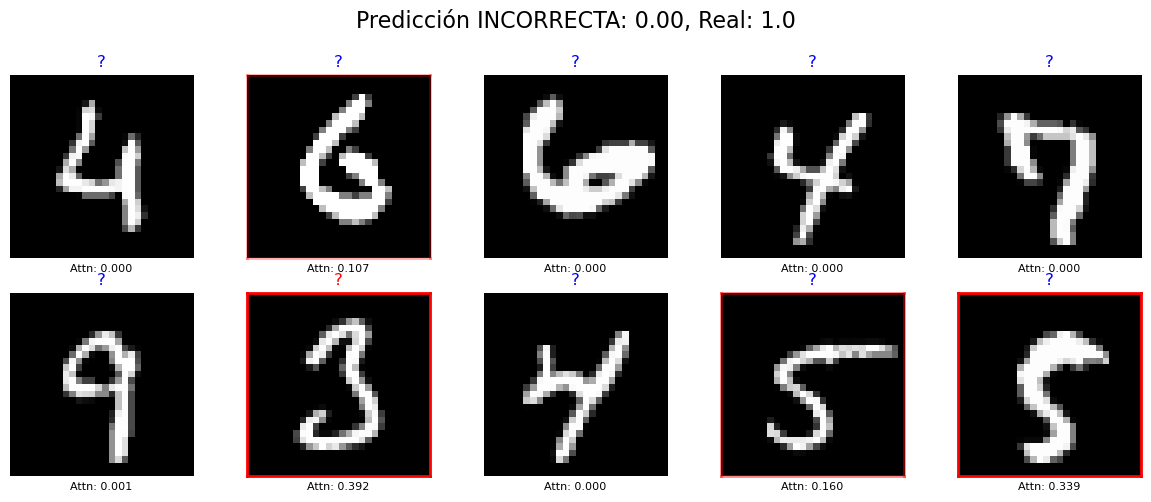

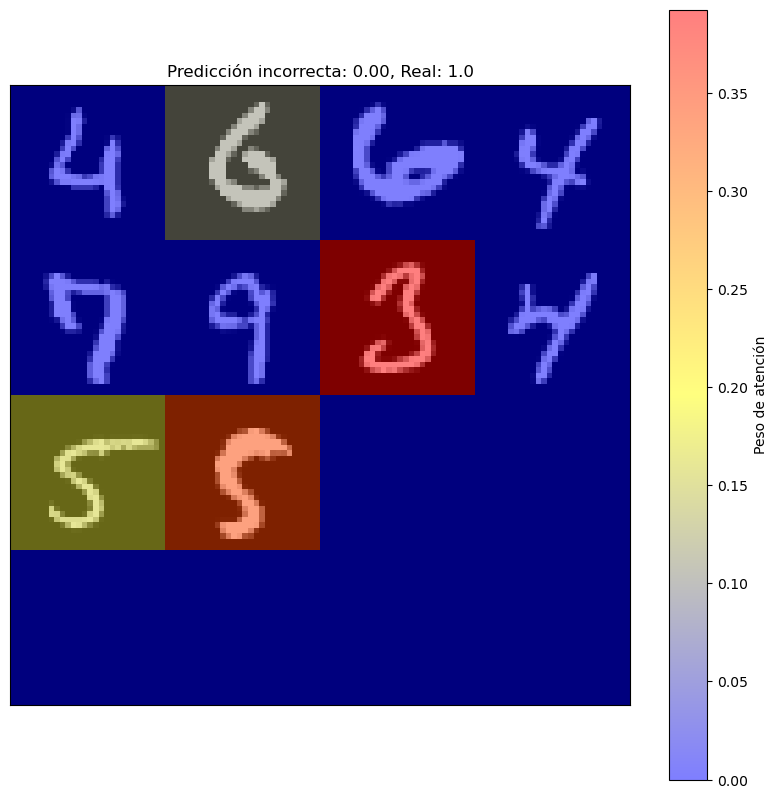

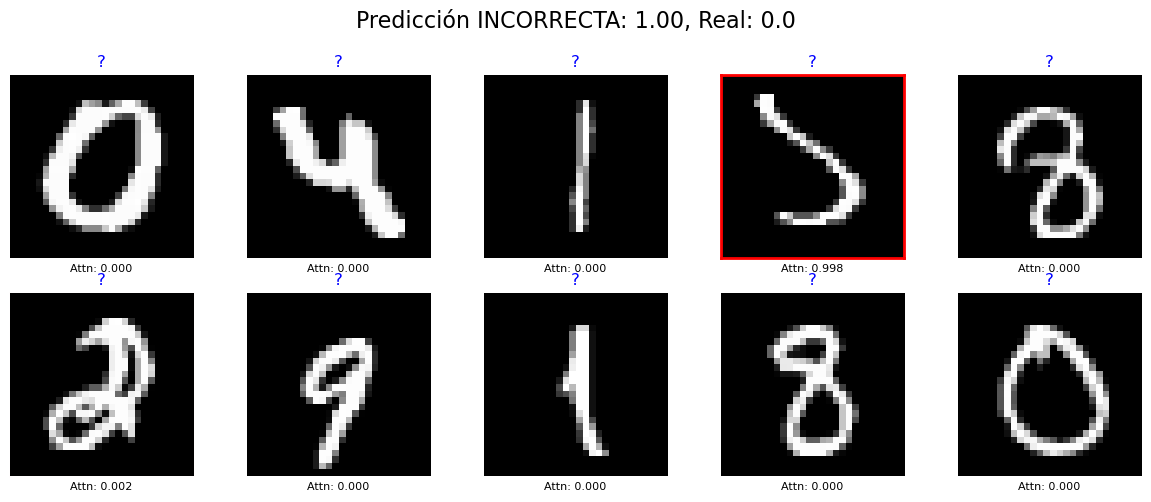

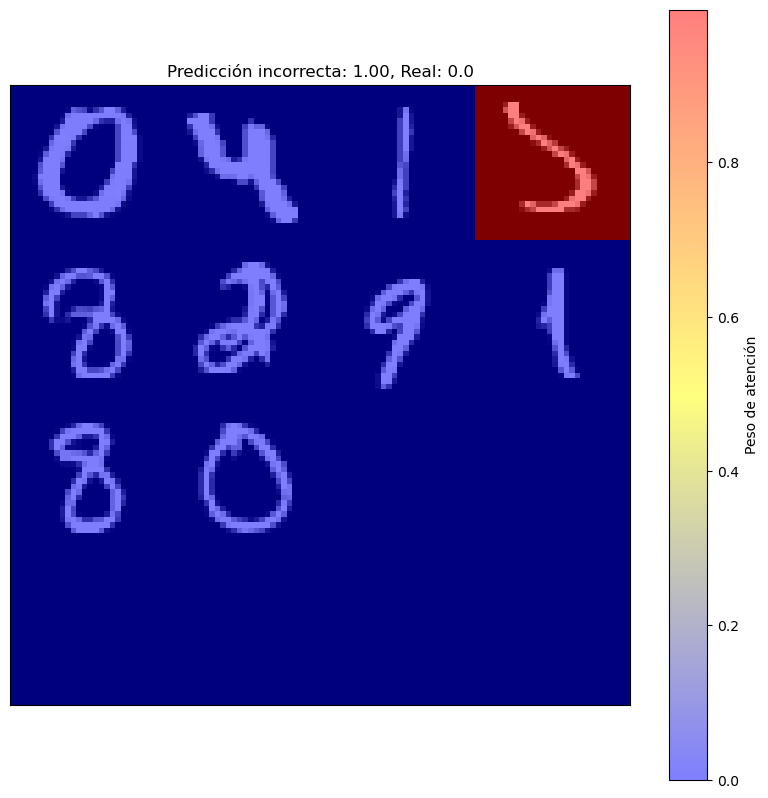

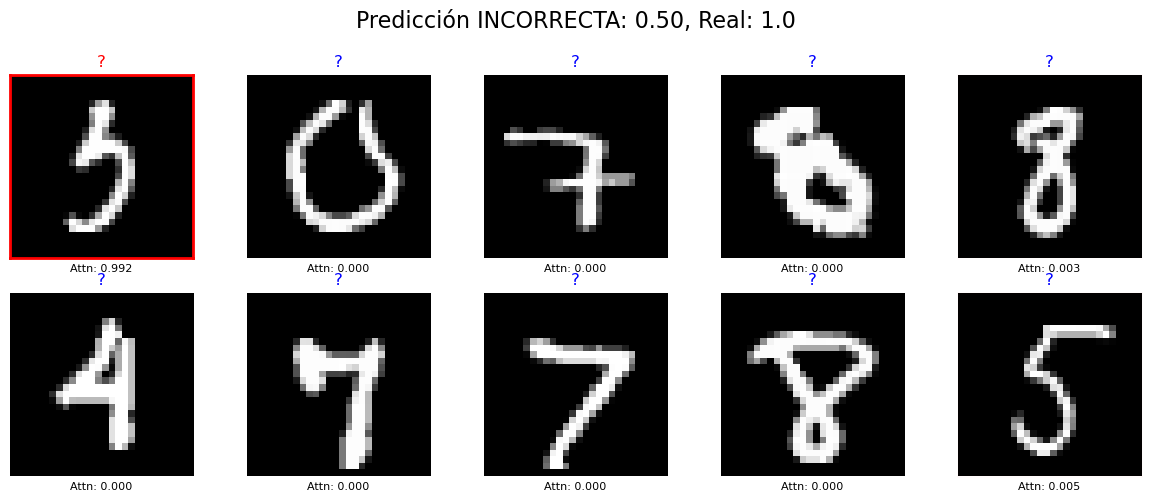

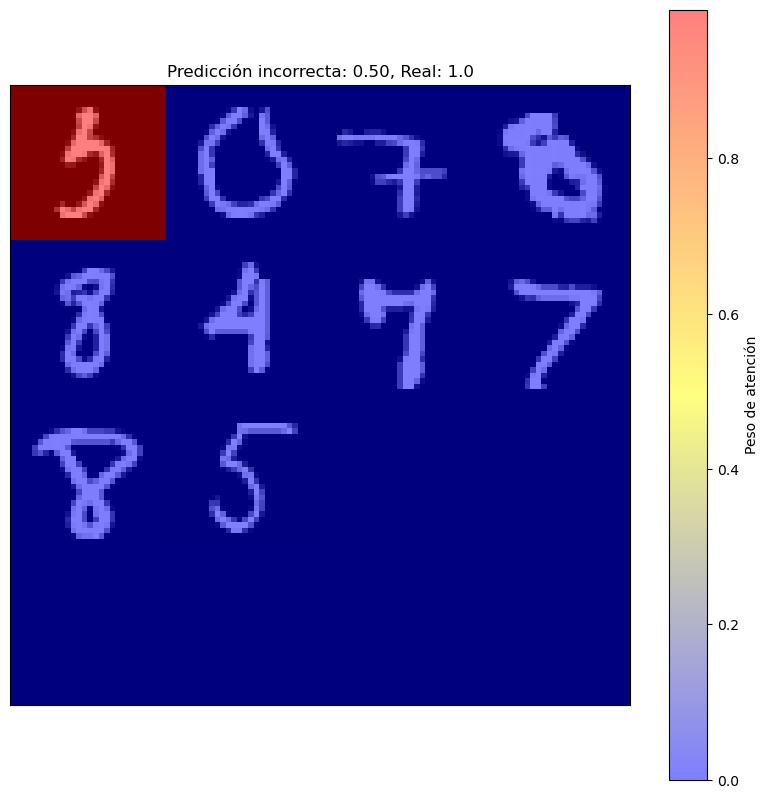


Análisis de atención:
Atención media en instancias con dígito 3: 0.6832 ± 0.3109
Atención media en instancias sin dígito 3: 0.0345 ± 0.1441


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


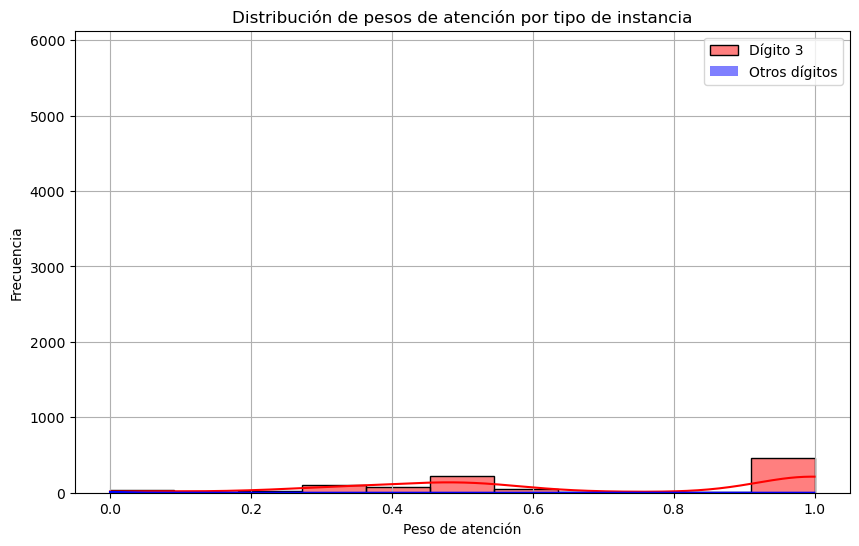

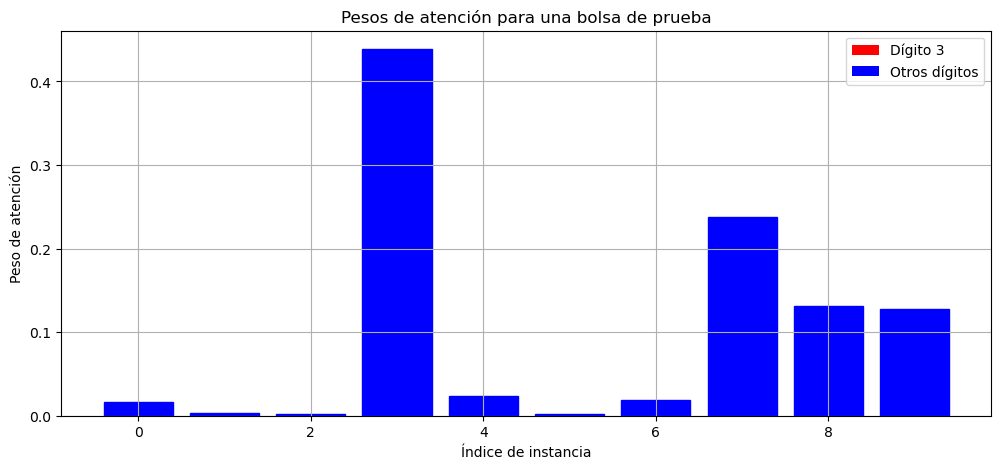

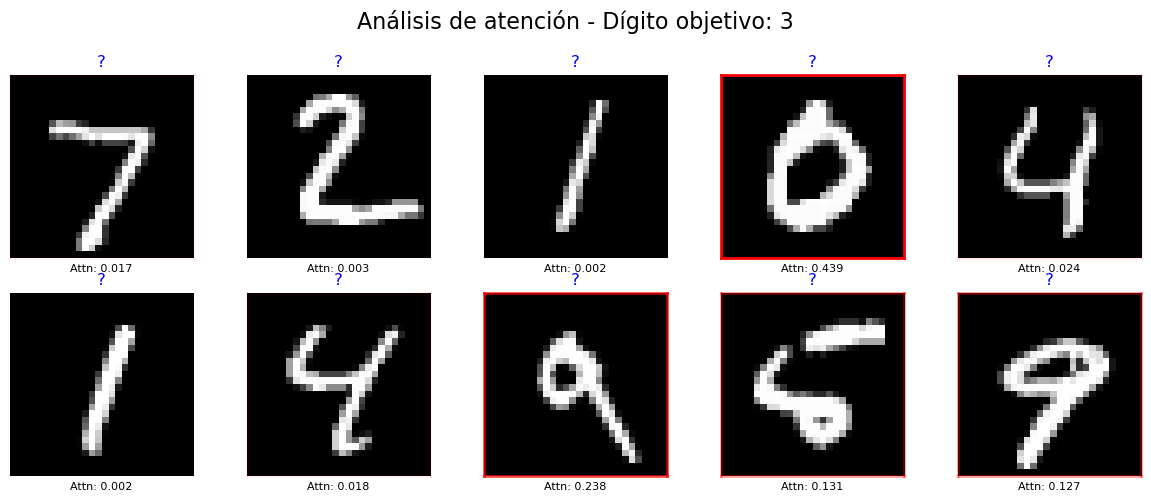

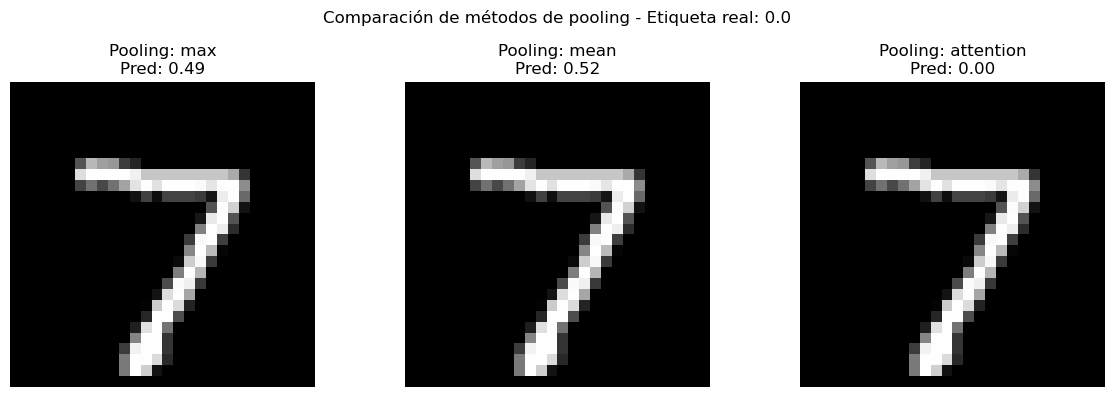

In [5]:
# Cell 1: Imports and setup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from scripts.MNIST.MNISTMILDataset import MNISTMILDataset
from scripts.MNIST.MNISTmodel import MILModel
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap

# Reproducibilidad
torch.manual_seed(42)

# Hyperparámetros
target_digit = 3       # Dígito objetivo para las bolsas
bag_size = 10          # Número de instancias por bolsa
num_epochs = 10        # Número de épocas
a_learning_rate = 1e-3  # Tasa de aprendizaje
batch_size = 1         # Tamaño de lote
pooling_type = 'attention'  # 'attention', 'mean' o 'max'

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Cell 2: Dataset y DataLoaders
full_train_dataset = MNISTMILDataset(subset='train', bag_size=bag_size, obj_label=target_digit)
test_dataset = MNISTMILDataset(subset='test', bag_size=bag_size, obj_label=target_digit)

# División train/validation
total_train = len(full_train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# DataLoaders
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

# Cell 3: Modelo, criterio y optimizador
model = MILModel(pooling_type=pooling_type).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=a_learning_rate)

# Función para visualizar una bolsa y sus etiquetas
def visualize_bag(bag, bag_label, inst_labels, lap=None, attn_weights=None, title=None, save_path=None):
    """
    Visualiza una bolsa de instancias MNIST con sus etiquetas y opcionalmente los pesos de atención.
    
    Args:
        bag: Tensor con las imágenes (batch_size, bag_size, 1, 28, 28)
        bag_label: Etiqueta de la bolsa (positiva o negativa)
        inst_labels: Etiquetas de cada instancia
        lap: Indices de los dígitos originales (para referencia)
        attn_weights: Opcional, pesos de atención por instancia
        title: Opcional, título para la visualización
        save_path: Opcional, ruta para guardar la imagen
    """
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    axes = axes.flatten()
    
    # Asegurarnos de que los tensores estén en CPU y con la forma correcta
    bag = bag.cpu()
    if bag.dim() == 5:  # Si incluye dimensión de batch
        bag = bag.squeeze(0)  # Eliminar dimensión de batch
        
    # Manejar correctamente las etiquetas de instancias
    if isinstance(inst_labels, torch.Tensor):
        if inst_labels.dim() > 1:
            inst_labels = inst_labels.squeeze(0)
        inst_labels = inst_labels.cpu().numpy()
    
    # Título principal
    bag_label_value = bag_label.item() if isinstance(bag_label, torch.Tensor) else bag_label
    if title is None:
        title = f"Bolsa {'POSITIVA' if bag_label_value > 0.5 else 'NEGATIVA'} - Dígito objetivo: {target_digit}"
    plt.suptitle(title, fontsize=16)
    
    # Visualizar cada instancia
    for i in range(bag_size):
        img = bag[i].squeeze().cpu().numpy()
        ax = axes[i]
        im = ax.imshow(img, cmap='gray')
        
        border_color = 'red' if inst_labels[i] == 1 else 'blue'
        
        # Manejar correctamente el tensor lap, que puede tener diferentes formas
        digit_label = None
        try:
            if isinstance(lap, torch.Tensor):
                digit_label = lap[i].item() if lap.dim() == 1 else lap[0][i].item()
            elif isinstance(lap, list):
                digit_label = lap[0][i].item() if isinstance(lap[0], torch.Tensor) else lap[0][i]
        except Exception:
            digit_label = "?"
            
        ax.set_title(f"{digit_label}", color=border_color)
        
        # Si hay pesos de atención, mostrarlos en el título
        if attn_weights is not None:
            ax.set_xlabel(f"Attn: {attn_weights[i]:.3f}", fontsize=8)
            # Añadir un borde coloreado según el peso de atención
            for spine in ax.spines.values():
                spine.set_linewidth(2)
                # Color más intenso para mayores pesos de atención
                intensity = min(1.0, attn_weights[i] * 3)
                spine.set_edgecolor((1.0, 0.0, 0.0, intensity))
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Función para visualizar un mapa de calor basado en atención
def visualize_attention_heatmap(bag, attn_weights, bag_label, prediction, save_path=None):
    """
    Genera un mapa de calor superpuesto para visualizar la atención sobre una bolsa.
    
    Args:
        bag: Tensor con las imágenes (bag_size, 1, 28, 28)
        attn_weights: Pesos de atención normalizados
        bag_label: Etiqueta real de la bolsa
        prediction: Predicción del modelo para la bolsa
        save_path: Opcional, ruta para guardar la imagen
    """
    # Crear un grid para todas las instancias
    bag = bag.cpu()
    if bag.dim() == 5:  # Si incluye dimensión de batch
        bag = bag.squeeze(0)  # Eliminar dimensión de batch
        
    grid_size = int(np.ceil(np.sqrt(bag_size)))
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Crear una imagen compuesta con todas las instancias
    composite_img = np.zeros((grid_size * 28, grid_size * 28))
    attn_map = np.zeros((grid_size * 28, grid_size * 28))
    
    for i in range(bag_size):
        row = i // grid_size
        col = i % grid_size
        img = bag[i].squeeze().cpu().numpy()
        composite_img[row*28:(row+1)*28, col*28:(col+1)*28] = img
        attn_map[row*28:(row+1)*28, col*28:(col+1)*28] = attn_weights[i]
    
    # Visualizar la imagen base
    ax.imshow(composite_img, cmap='gray', alpha=1.0)
    
    # Superponer mapa de calor de atención
    cmap = LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'yellow', 'red'])
    heat = ax.imshow(attn_map, cmap=cmap, alpha=0.5)
    
    # Añadir barra de color
    cbar = plt.colorbar(heat, ax=ax)
    cbar.set_label('Peso de atención')
    
    # Título
    bag_label_value = bag_label.item() if isinstance(bag_label, torch.Tensor) else bag_label
    correct = (bag_label_value > 0.5) == (prediction > 0.5)
    title = f"Predicción {'correcta' if correct else 'incorrecta'}: {prediction:.2f}, Real: {bag_label_value}"
    ax.set_title(title)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# Cell 4: Loop de entrenamiento con visualización
def train():
    model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(1, num_epochs+1):
        # Entrenamiento
        model.train()
        total_loss = 0.0
        for bag, bag_label, inst_labels, lap in dataloader_train:
            bag = bag.to(device)
            bag_label = bag_label.to(device)
            
            optimizer.zero_grad()
            output, attn = model(bag)
            loss = criterion(output.squeeze(-1), bag_label)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(dataloader_train)
        train_losses.append(avg_train_loss)
        
        # Validación
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for bag, bag_label, inst_labels, lap in dataloader_val:
                bag = bag.to(device)
                bag_label = bag_label.to(device)
                output, attn = model(bag)
                loss = criterion(output.squeeze(-1), bag_label)
                val_loss += loss.item()
                
                pred = (output.squeeze(-1) > 0.5).float()
                correct += (pred == bag_label).sum().item()
                total += bag_label.size(0)
        
        avg_val_loss = val_loss / len(dataloader_val)
        val_acc = correct / total
        val_losses.append(avg_val_loss)
        
        print(f"Época {epoch}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Visualizar una bolsa de validación cada 2 épocas
        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                # Obtener una muestra de validación
                val_bag, val_label, val_inst_labels, val_lap = next(iter(dataloader_val))
                val_bag = val_bag.to(device)
                val_pred, val_attn = model(val_bag)
                val_attn = val_attn.cpu().numpy()[0]
                
                # Visualizar la bolsa con pesos de atención
                pred_value = val_pred.item() if val_pred.numel() == 1 else val_pred.squeeze().item()
                visualize_bag(
                    val_bag.cpu(), 
                    val_label, 
                    val_inst_labels, 
                    val_lap,
                    val_attn, 
                    title=f"Época {epoch} - Bolsa de validación (pred={pred_value:.2f})"
                )
    
    # Visualizar curvas de pérdida
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Curvas de pérdida durante el entrenamiento')
    plt.legend()
    plt.grid(True)
    plt.show()

# Entrenar el modelo
train()

# Cell 5: Evaluación en test set con visualizaciones
model.eval()
all_outputs = []
all_labels = []
all_attentions = []
all_bags = []
all_inst_labels = []
all_laps = []

with torch.no_grad():
    for bag, bag_label, inst_labels, lap in dataloader_test:
        bag = bag.to(device)
        bag_label = bag_label.to(device)
        output, attn = model(bag)
        
        all_outputs.append(output.cpu())
        all_labels.append(bag_label.cpu())
        if pooling_type == 'attention':
            all_attentions.append(attn.cpu())
        
        # Guardar las bolsas y etiquetas para visualizaciones
        all_bags.append(bag.cpu())
        all_inst_labels.append(inst_labels)
        all_laps.append(lap)

# Convertir listas a tensores
torch_outputs = torch.cat(all_outputs).squeeze()
torch_labels = torch.cat(all_labels)
torch_preds = (torch_outputs > 0.5).float()

# Métricas
accuracy = (torch_preds == torch_labels).float().mean()
print(f"Accuracy en test: {accuracy:.4f}")

# Matriz de confusión
cm = confusion_matrix(torch_labels.numpy(), torch_preds.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negativo', 'Positivo'], 
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(torch_labels.numpy(), torch_outputs.numpy())
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Visualización de casos correctos e incorrectos
correct_indices = (torch_preds == torch_labels).nonzero().squeeze().numpy()
incorrect_indices = (torch_preds != torch_labels).nonzero().squeeze().numpy()

# Asegurarse de que los índices sean iterables incluso si solo hay uno
if isinstance(correct_indices, np.ndarray) and correct_indices.size == 1:
    correct_indices = [correct_indices.item()]
elif not hasattr(correct_indices, "__len__"):
    correct_indices = [correct_indices]
    
if isinstance(incorrect_indices, np.ndarray) and incorrect_indices.size == 1:
    incorrect_indices = [incorrect_indices.item()]
elif not hasattr(incorrect_indices, "__len__"):
    incorrect_indices = [incorrect_indices]

print(f"Predicciones correctas: {len(correct_indices)}")
print(f"Predicciones incorrectas: {len(incorrect_indices)}")

# Visualizar casos correctos
if len(correct_indices) > 0:
    # Seleccionar hasta 3 casos correctos aleatorios
    samples = np.random.choice(correct_indices, size=min(3, len(correct_indices)), replace=False)
    for idx in samples:
        bag = all_bags[idx]
        bag_label = torch_labels[idx]
        inst_labels = all_inst_labels[idx]
        lap = all_laps[idx]
        prediction = torch_outputs[idx].item()
        
        # Visualizar la bolsa
        visualize_bag(
            bag, 
            bag_label, 
            inst_labels, 
            lap,
            all_attentions[idx][0].numpy() if pooling_type == 'attention' else None,
            title=f"Predicción CORRECTA: {prediction:.2f}, Real: {bag_label.item()}"
        )
        
        # Visualizar mapa de calor si estamos usando atención
        if pooling_type == 'attention':
            visualize_attention_heatmap(
                bag,
                all_attentions[idx][0].numpy(),
                bag_label,
                prediction
            )

# Visualizar casos incorrectos
if len(incorrect_indices) > 0:
    # Seleccionar hasta 3 casos incorrectos aleatorios
    samples = np.random.choice(incorrect_indices, size=min(3, len(incorrect_indices)), replace=False)
    for idx in samples:
        bag = all_bags[idx]
        bag_label = torch_labels[idx]
        inst_labels = all_inst_labels[idx]
        lap = all_laps[idx]
        prediction = torch_outputs[idx].item()
        
        # Visualizar la bolsa
        visualize_bag(
            bag, 
            bag_label, 
            inst_labels, 
            lap,
            all_attentions[idx][0].numpy() if pooling_type == 'attention' else None,
            title=f"Predicción INCORRECTA: {prediction:.2f}, Real: {bag_label.item()}"
        )
        
        # Visualizar mapa de calor si estamos usando atención
        if pooling_type == 'attention':
            visualize_attention_heatmap(
                bag,
                all_attentions[idx][0].numpy(),
                bag_label,
                prediction
            )

# Análisis de atención (específico para pooling de atención)
if pooling_type == 'attention':
    # Calcular correlación entre atención y presencia del dígito objetivo
    print("\nAnálisis de atención:")
    
    # Recopilar datos para análisis
    attn_on_target = []
    attn_on_nontarget = []
    
    for idx in range(len(all_bags)):
        bag_attn = all_attentions[idx][0].numpy()
        inst_labels = all_inst_labels[idx].squeeze().numpy()
        
        for i in range(bag_size):
            if inst_labels[i] == 1:  # Instancia con dígito objetivo
                attn_on_target.append(bag_attn[i])
            else:  # Instancia sin dígito objetivo
                attn_on_nontarget.append(bag_attn[i])
    
    # Convertir a arrays de numpy
    attn_on_target = np.array(attn_on_target)
    attn_on_nontarget = np.array(attn_on_nontarget)
    
    # Estadísticas descriptivas
    print(f"Atención media en instancias con dígito {target_digit}: {attn_on_target.mean():.4f} ± {attn_on_target.std():.4f}")
    print(f"Atención media en instancias sin dígito {target_digit}: {attn_on_nontarget.mean():.4f} ± {attn_on_nontarget.std():.4f}")
    
    # Visualizar distribución de atención
    plt.figure(figsize=(10, 6))
    sns.histplot(attn_on_target, color='red', alpha=0.5, label=f'Dígito {target_digit}', kde=True)
    sns.histplot(attn_on_nontarget, color='blue', alpha=0.5, label='Otros dígitos', kde=True)
    plt.xlabel('Peso de atención')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de pesos de atención por tipo de instancia')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualización de pesos de atención (independiente del tipo de pooling)
# Obtenemos una bolsa específica para analizar
sample_idx = 0  # Podemos cambiar este índice según interés
bag, bag_label, inst_labels, lap = (
    all_bags[sample_idx], 
    torch_labels[sample_idx], 
    all_inst_labels[sample_idx], 
    all_laps[sample_idx]
)

# Para pooling de atención, visualizamos los pesos de atención
if pooling_type == 'attention':
    attn_weights = all_attentions[sample_idx][0].numpy()
    
    # Visualizar pesos de atención como barras
    plt.figure(figsize=(12, 5))
    bars = plt.bar(range(len(attn_weights)), attn_weights)
    plt.xlabel('Índice de instancia')
    plt.ylabel('Peso de atención')
    plt.title('Pesos de atención para una bolsa de prueba')
    
    # Colorear las barras según si contienen el dígito objetivo
    inst_labels_np = inst_labels.squeeze().numpy()
    for i, bar in enumerate(bars):
        bar.set_color('red' if inst_labels_np[i] == 1 else 'blue')
    
    # Añadir leyenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', label=f'Dígito {target_digit}'),
        Patch(facecolor='blue', label='Otros dígitos')
    ]
    plt.legend(handles=legend_elements)
    
    plt.grid(True)
    plt.show()
    
    # Obtener la bolsa completa para visualizar junto con la atención
    visualize_bag(
        bag, 
        bag_label, 
        inst_labels, 
        lap,
        attn_weights,
        title=f"Análisis de atención - Dígito objetivo: {target_digit}"
    )

# Para cualquier tipo de pooling, visualizamos la bolsa y su predicción
else:
    with torch.no_grad():
        bag_tensor = bag.to(device)
        output, _ = model(bag_tensor)
        prediction = output.cpu().item()
    
    visualize_bag(
        bag, 
        bag_label, 
        inst_labels, 
        lap,
        title=f"Predicción: {prediction:.2f} - Tipo de pooling: {pooling_type}"
    )

# Comparación de métodos de pooling (si hay interés en comparar)
def compare_pooling_methods():
    """
    Comparar diferentes métodos de pooling en la misma bolsa.
    """
    # Guardar los pesos originales del modelo con pooling actual
    original_state_dict = model.state_dict()
    
    # Seleccionar una bolsa para análisis
    bag, bag_label, inst_labels, lap = next(iter(dataloader_test))
    
    results = {}
    pooling_types = ['max', 'mean', 'attention']
    
    for pool_type in pooling_types:
        # Crear un modelo con el tipo de pooling específico
        temp_model = MILModel(pooling_type=pool_type).to(device)
        
        # Si es el mismo tipo de pooling que el original, usar los pesos entrenados
        if pool_type == pooling_type:
            temp_model.load_state_dict(original_state_dict)
        
        # Evaluar
        temp_model.eval()
        with torch.no_grad():
            bag_tensor = bag.to(device)
            output, attn = temp_model(bag_tensor)
            prediction = output.cpu().item()
        
        results[pool_type] = {
            'prediction': prediction,
            'attention': attn.cpu().numpy()[0] if pool_type == 'attention' else None
        }
    
    # Visualizar resultados
    plt.figure(figsize=(12, 4))
    for i, pool_type in enumerate(pooling_types):
        plt.subplot(1, 3, i+1)
        plt.title(f"Pooling: {pool_type}\nPred: {results[pool_type]['prediction']:.2f}")
        
        # La bolsa es la misma, solo mostramos una imagen representativa
        representative_idx = 0
        img = bag[0, representative_idx, 0].numpy()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"Comparación de métodos de pooling - Etiqueta real: {bag_label.item()}")
    plt.subplots_adjust(top=0.8)
    plt.show()
    
    # Restaurar el modelo original
    model.load_state_dict(original_state_dict)

# Ejecutar comparación de pooling si se desea
compare_pooling_methods()